## Predicting Real Estate Data in St. Petersburg
We have data from Yandex.Realty classified https://realty.yandex.ru containing real estate listings for apartments in St. Petersburg and Leningrad Oblast from 2016 till the middle of August 2018. In this Lab you'll learn how to apply machine learning algorithms to solve business problems. Accurate price prediction can help to find fraudsters automatically and help Yandex.Realty users to make better decisions when buying and selling real estate.

Using python with machine learning algotithms is the #1 option for prototyping solutions among data scientists today. We'll take a look at it in this lab.

### Main objectives
After successful completion of the lab work students will be able to:
-	Apply machine learning for solving price prediction problem
-   Calculate metrics which can help us find out whether our machine learning model is ready for production



### 1. Load data with real estate prices

In [1]:
# let's import pandas library and set options to be able to view data right in the browser
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.style as style
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)
style.use('fivethirtyeight')


In [2]:
rent_df = pd.read_csv('sells_result.csv')

Obviously, it is not rented but sold flats but I have realized that the name is strange too late

In [3]:
rent_df.head()

,Unnamed: 0,offer_id,first_day_exposition,last_day_exposition,last_price,floor,open_plan,rooms,studio,area,kitchen_area,living_area,agent_fee,renovation,offer_type,category_type,unified_address,building_id,SPs or LenObl,price_per_sq_m,house_price_sqm_median_cleaned,price_for_rent,years_for_payback,days_exposition
0,0,5490504238877583424,2014-11-27,2016-03-14,3676740.0,19,False,1,False,27.40,16.56,16.56,0.0,0.0,1,2,"Россия, Санкт-Петербург, улица Шкапина, 9-11",3552413344225333068,SPb,134187.591241,710.818713,19476.432749,28,473
1,1,5490504238903444021,2014-11-27,2016-04-28,7038880.0,2,False,3,False,85.84,19.64,41.20,0.0,0.0,1,2,"Россия, Санкт-Петербург, Кушелевская дорога, 3к4",7274736308217971906,SPb,82000.000000,611.111111,52457.777778,15,518
2,2,5490504238903447743,2014-11-27,2016-05-11,7038880.0,3,False,3,False,85.84,19.64,41.20,0.0,0.0,1,2,"Россия, Санкт-Петербург, Кушелевская дорога, 3к4",7274736308217971906,SPb,82000.000000,611.111111,52457.777778,15,531
3,3,5490504238877673946,2014-11-27,2016-05-12,12074400.0,5,False,3,False,93.60,10.90,52.00,0.0,0.0,1,2,"Россия, Санкт-Петербург, Свердловская набережная, 58А",5917543958366039686,SPb,129000.000000,658.653846,61650.000000,30,532
4,4,5490504238877648740,2014-11-27,2016-05-12,20406100.0,7,False,4,False,142.70,13.84,82.55,0.0,0.0,1,2,"Россия, Санкт-Петербург, Свердловская набережная, 58А",5917543958366039686,SPb,143000.000000,658.653846,93989.903846,40,532


In [4]:
numeric_features = rent_df.select_dtypes('number').columns.tolist()
nominal_features = rent_df.select_dtypes(object).columns

In [5]:
numeric_features

['Unnamed: 0',
 'offer_id',
 'last_price',
 'floor',
 'rooms',
 'area',
 'kitchen_area',
 'living_area',
 'agent_fee',
 'renovation',
 'offer_type',
 'category_type',
 'building_id',
 'price_per_sq_m',
 'house_price_sqm_median_cleaned',
 'price_for_rent',
 'days_exposition']

In [6]:
numeric_features=numeric_features[2:]

In [7]:
from datetime import datetime
rent_df['last_day_exposition']=list(map(lambda x: datetime.strptime(x[:10],'%Y-%m-%d'),rent_df['last_day_exposition']))

In [8]:
rent_df['first_day_exposition']=list(map(lambda x: datetime.strptime(x[:10],'%Y-%m-%d'),rent_df['first_day_exposition']))
rent_df['days_exposition']=rent_df['last_day_exposition']-rent_df['first_day_exposition']
rent_df['days_exposition']=list(map(lambda x: int(str(x).split(' ')[0]),rent_df['days_exposition']))

Well, not all of the features can be used as numeric ones so we need to make them dummies. That is why we will choose nominal amd numeric features and then use one hot encoder for nominal features and simple imputer for empty numeric features

In [9]:
nominal_features=['category_type','renovation']
numeric_features= ['last_price',
 'floor',
 'rooms',
 'area',
 'kitchen_area',
 'living_area',
 'agent_fee',
 'price_per_sq_m',
 'house_price_sqm_median_cleaned',
 'days_exposition',
 'price_for_rent']

In [10]:
numeric_features

['last_price',
 'floor',
 'rooms',
 'area',
 'kitchen_area',
 'living_area',
 'agent_fee',
 'price_per_sq_m',
 'house_price_sqm_median_cleaned',
 'days_exposition',
 'price_for_rent']

In [11]:

def create_dataset(dataset,simple_imputer_condition_strategy,numeric_features):
    result=DataFrameMapper([([feature], SimpleImputer(strategy=simple_imputer_condition_strategy)) for feature in numeric_features] +\
                         [([feature], OneHotEncoder(handle_unknown = 'ignore')) for feature in nominal_features], 
                            df_out=True)
    result=result.fit_transform(dataset)

    
    return result

def standart_sc(train,test):
    result_d=StandardScaler().fit(train[numeric_features_for_prep])
    train[numeric_features_for_prep]=StandardScaler().fit_transform(train[numeric_features_for_prep])
    test[numeric_features_for_prep]=result_d.fit_transform(test[numeric_features_for_prep])
    return train, test, result_d
def inverse_st_pred(price,x_test,result_d):
    x_test_pr=x_test.copy()
    x_test_pr['price']=price
    x_test_pr[numeric_features_for_prep]=result_d.inverse_transform(x_test_pr[numeric_features_for_prep])
    return x_test_pr['price']

In [12]:
pip install sklearn_pandas

  Using cached sklearn_pandas-2.2.0-py2.py3-none-any.whl (10 kB)

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [13]:
pip install scikit-learn --upgrade


  Using cached scikit_learn-1.2.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.6 MB)
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Attempting uninstall: joblib
    Found existing installation: joblib 1.0.1
    Uninstalling joblib-1.0.1:
      Successfully uninstalled joblib-1.0.1
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.2
    Uninstalling scikit-learn-0.24.2:
      Successfully uninstalled scikit-learn-0.24.2

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [14]:
pip install sklearn


  Using cached sklearn-0.0.post5-py3-none-any.whl

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [15]:
pip install xgboost


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [16]:

import numpy as np
import pandas as pd
# https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html
from sklearn.impute import SimpleImputer

# https://dunyaoguz.github.io/my-blog/dataframemapper.html
from sklearn_pandas import DataFrameMapper

# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette('muted')
sns.set_color_codes('muted')
sns.set_style('white')

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import PredictionErrorDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.linear_model import LinearRegression

I want to compare one by one several (three) models and identify the best one

In [17]:
rent_df.columns

Index(['Unnamed: 0', 'offer_id', 'first_day_exposition', 'last_day_exposition', 'last_price', 'floor', 'open_plan', 'rooms', 'studio', 'area', 'kitchen_area', 'living_area', 'agent_fee', 'renovation', 'offer_type', 'category_type', 'unified_address', 'building_id', 'SPs or LenObl', 'price_per_sq_m', 'house_price_sqm_median_cleaned', 'price_for_rent', 'years_for_payback', 'days_exposition'], dtype='object')

In [18]:
dataset=create_dataset(rent_df,'mean',numeric_features)

In [19]:
dataset=rent_df[numeric_features].copy()

In [20]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187901 entries, 0 to 187900
Data columns (total 11 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   last_price                      187901 non-null  float64
 1   floor                           187901 non-null  int64  
 2   rooms                           187901 non-null  int64  
 3   area                            187901 non-null  float64
 4   kitchen_area                    187901 non-null  float64
 5   living_area                     187901 non-null  float64
 6   agent_fee                       187901 non-null  float64
 7   price_per_sq_m                  187901 non-null  float64
 8   house_price_sqm_median_cleaned  187901 non-null  float64
 9   days_exposition                 187901 non-null  int64  
 10  price_for_rent                  187901 non-null  float64
dtypes: float64(8), int64(3)
memory usage: 15.8 MB


In [21]:
train,test=train_test_split(dataset, test_size = 0.3)
x_train=train.drop(columns='last_price')
y_train=train.last_price.copy()
x_test=test.drop(columns='last_price')
y_test=test.last_price.copy()

In [22]:
first_tree = DecisionTreeRegressor(random_state=17)

In [23]:
from sklearn.model_selection import cross_val_score

In [24]:
cross_val_score(first_tree, x_train, y_train, cv=5)

array([0.99899164, 0.99925122, 0.99891844, 0.99903185, 0.99893715])

In [53]:
np.mean(cross_val_score(first_tree, x_train, y_train, cv=5))

0.9990448500793947

In [54]:
from sklearn.model_selection import GridSearchCV  

In [55]:
tree_params = {'max_depth':np.arange(1,10)}

In [56]:
tree_grid = GridSearchCV(first_tree, tree_params, cv = 5, n_jobs=-1)


In [57]:
%time
tree_grid.fit(x_train, y_train);

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs


In [58]:
tree_grid.best_score_, tree_grid.best_params_

(0.9939603450640193, {'max_depth': 9})

In [59]:
tree_grid.best_estimator_

DecisionTreeRegressor(max_depth=9, random_state=17)

In [60]:
tree_valid_pred = tree_grid.predict(x_test)

In [61]:
tree_train_pred = tree_grid.predict(x_train)

In [62]:
mean_absolute_percentage_error(y_true=y_test, y_pred = tree_valid_pred)

0.03431885078262534

In [63]:
mean_absolute_percentage_error(y_true=y_train, y_pred = tree_train_pred)

0.032924388481039735

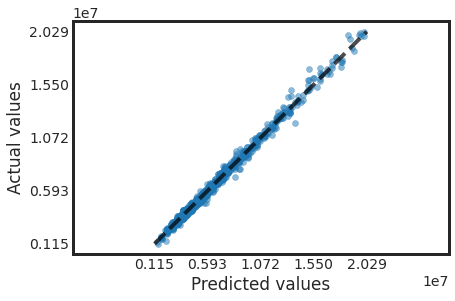

In [64]:
from sklearn.metrics import PredictionErrorDisplay

PredictionErrorDisplay.from_predictions(
    y_test,
    tree_valid_pred,
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
)
plt.show()

In [65]:
max_depth=8
n_estimators=400
params = {'max_depth': max_depth,
  'n_estimators': n_estimators,
  'learning_rate': 0.3,
  'gamma': 0.1,
  'reg_lambda': 1}
modelxgb=xgb.XGBRegressor(**params)
modelxgb.fit(x_train,y_train)
y_pred_xgb_test=modelxgb.predict(x_test)
y_pred_xgb_train=modelxgb.predict(x_train)



In [67]:
mean_absolute_percentage_error(y_true=y_train, y_pred = y_pred_xgb_train)

0.0029177544450420655

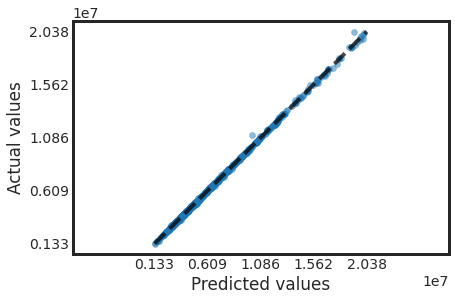

In [68]:
from sklearn.metrics import PredictionErrorDisplay

PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_xgb_test,
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
)
plt.show()

In [69]:
model=LinearRegression(positive=True).fit(x_train,y_train)
y_pred_l_test=model.predict(x_test)
y_pred_l_train=model.predict(x_train)

In [70]:
mean_absolute_percentage_error(y_true=y_test, y_pred = y_pred_l_test)

0.09282723217570404

In [71]:
mean_absolute_percentage_error(y_true=y_train, y_pred = y_pred_l_train)

0.09157663577951394

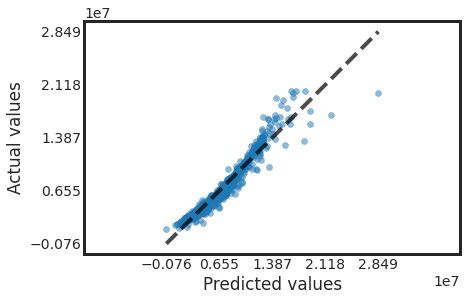

In [72]:
from sklearn.metrics import PredictionErrorDisplay

PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_l_test,
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
)
plt.show()

Well, the best option here is xgboost model but it has a tendency to overfit. To check the results it is better to remake train and test splits several times with other random splits in the future

In [25]:
model_final=xgb.XGBRegressor(max_depth=8,n_estimators=400,learning_rate=0.3,gamma=0.1,reg_lambda=1)
model_final.fit(dataset.drop(columns='last_price'),dataset['last_price'])


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.1, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.3, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=8, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=400, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [26]:
dataset.drop(columns='last_price').columns

Index(['floor', 'rooms', 'area', 'kitchen_area', 'living_area', 'agent_fee', 'price_per_sq_m', 'house_price_sqm_median_cleaned', 'days_exposition', 'price_for_rent'], dtype='object')

In [75]:
import joblib

In [76]:
model_file = 'modelxgb.pkl'
joblib.dump(model_final, model_file)



['modelxgb.pkl']